In [11]:
import statsmodels.formula.api as sm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [12]:
df_dev = pd.read_csv('../dataset/development.csv')
df_eval = pd.read_csv('../dataset/evaluation.csv')

In [13]:
def final_preprocessing(df, reduce_df=True):
    working_df_dev = df.copy()

    enc = OneHotEncoder()
    encoded_df = pd.concat([df['weekday'], df['data_channel']], axis=1)
    enc.fit(encoded_df)
    encoded_df = enc.transform(encoded_df)
    additional_columns = enc.get_feature_names_out()
    working_df_dev[additional_columns] = encoded_df.toarray()
    working_df_dev.drop(['weekday', 'data_channel', 'url', 'id'], axis = 1, inplace=True)

    working_df_dev['num_keywords'] = df.groupby(['data_channel'], sort=False)['num_keywords'].apply(lambda x: x.fillna(x.mean())).reset_index()['num_keywords']

    working_df_dev['n_tokens_content'] = np.log(1 + working_df_dev['n_tokens_content'])

    if 'shares' in working_df_dev:
        working_df_dev['shares'] = np.log(working_df_dev['shares'])

    if reduce_df:
        # Remove outliers from kw_avg_avg (we lost another 9% of the dataset)
        q1 = working_df_dev['kw_avg_avg'].describe()['25%']
        q3 = working_df_dev['kw_avg_avg'].describe()['75%']
        iqr = q3 - q1
        min_kw_avg_avg = q1 - 1.5*iqr
        max_kw_avg_avg = q3 + 1.5*iqr
        working_df_dev = working_df_dev[(df.kw_avg_avg < max_kw_avg_avg) & (df.kw_avg_avg > min_kw_avg_avg)]

    std_scaler = StandardScaler().fit(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg', 'kw_max_avg', 'kw_max_min', 'kw_min_max']])
    scaled_features = std_scaler.transform(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']])
    working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']] = scaled_features

    std_scaler = StandardScaler().fit(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
    scaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
    working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features

    std_scaler = StandardScaler().fit(working_df_dev[['n_tokens_title', 'n_tokens_content']])
    scaled_features = std_scaler.transform(working_df_dev[['n_tokens_title', 'n_tokens_content']])
    working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features

    working_df_dev['num_imgs'].fillna(working_df_dev['num_imgs'].mean(), inplace=True)
    working_df_dev['num_imgs'] = np.log(1 + working_df_dev['num_imgs'])

    working_df_dev['num_self_hrefs'].fillna(working_df_dev['num_self_hrefs'].mean(), inplace=True)
    working_df_dev['num_self_hrefs'] = np.log(1 + working_df_dev['num_self_hrefs'])

    working_df_dev['num_videos'].fillna(working_df_dev['num_videos'].mean(), inplace=True)
    working_df_dev['num_videos'] = np.log(1 + working_df_dev['num_videos'])

    is_weekend = []
    for _, row in working_df_dev.iterrows():
        if row['weekday_sunday'] == 1 or row['weekday_saturday'] == 1:
            is_weekend.append(1)
        else:
            is_weekend.append(0)
    working_df_dev['is_weekend'] = is_weekend
    working_df_dev.drop(columns=[x for x in additional_columns if x.startswith('weekday')], inplace=True)


    std_scaler = StandardScaler().fit(working_df_dev[['timedelta']])
    scaled_features = std_scaler.transform(working_df_dev[['timedelta']])
    working_df_dev[['timedelta']] = scaled_features

    return working_df_dev


def corrX_orig(df, cut = 0.9) :
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool_))

    drop = list()

    # For loop implements this pseudocode
    # For every cell in the upper triangle:
    # If cell.value > 0.6:
    # If mean(row_correlation) > mean(column_correlation):drop(column)
    # Else: drop(row)
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if corr_mtx.iloc[row, col] > cut:
                if avg_corr.iloc[row] > avg_corr.iloc[col]:
                    drop.append(row)
                else:
                    drop.append(col)

    drop_set = list(set(drop))
    # dropcols_idx = drop_set
    dropcols_names = list(df.columns[[item for item in drop_set]])

    return dropcols_names

def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))

    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))

    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop
    poss_drop = list(set(poss_drop).difference(set(drop)))

    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]

    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)

    return drop

def corrX_new(df, cut = 0.9):
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool_))
    dropcols = list()

    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target',
                                 'v2.target','corr', 'drop' ]))
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if corr_mtx.iloc[row, col] > cut:
                if avg_corr.iloc[row] > avg_corr.iloc[col]:
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else:
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]

                s = pd.Series([ corr_mtx.index[row],
                                up.columns[col],
                                avg_corr[row],
                                avg_corr[col],
                                up.iloc[row,col],
                                drop],
                              index = res.columns)

                res.loc[len(res)] = s.to_numpy()

    dropcols_names = calcDrop(res)

    return dropcols_names

In [14]:
working_df_dev = final_preprocessing(df_dev)

drop_new = corrX_new(working_df_dev, cut = 0.7)

working_df_dev.drop(drop_new, axis=1, inplace=True)

/var/tmp/ipykernel_334579/370202585.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  working_df_dev['num_keywords'] = df.groupby(['data_channel'], sort=False)['num_keywords'].apply(lambda x: x.fillna(x.mean())).reset_index()['num_keywords']


In [17]:
working_df_dev['kw_min_min'] = working_df_dev['kw_min_min'].apply(lambda x: working_df_dev['kw_min_min'].mean() if x == -1 else x)

In [22]:
working_df_dev.iloc[:,31:].describe()

,abs_title_subjectivity,shares,data_channel_bus,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,is_weekend
count,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000
mean,0.342228,7.453556,0.161493,0.181717,0.186057,0.059849,0.192075,0.131240
std,0.188982,0.911482,0.367991,0.385617,0.389159,0.237210,0.393938,0.337668
min,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,6.846146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,7.244228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,7.901007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.500000,13.645078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
svr = SVR(C= 1, epsilon= 0.5, gamma= 'auto', kernel= 'rbf', shrinking= False, tol= 0.001)
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)
svr.fit(X_train, y_train)

SVR(C=1, epsilon=0.5, gamma='auto', shrinking=False)

In [24]:
rms = mean_squared_error(y_valid, svr.predict(X_valid), squared=False)
print(rms)
r2 = r2_score(y_valid, svr.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

0.8520766299346891
0.10736592755520469


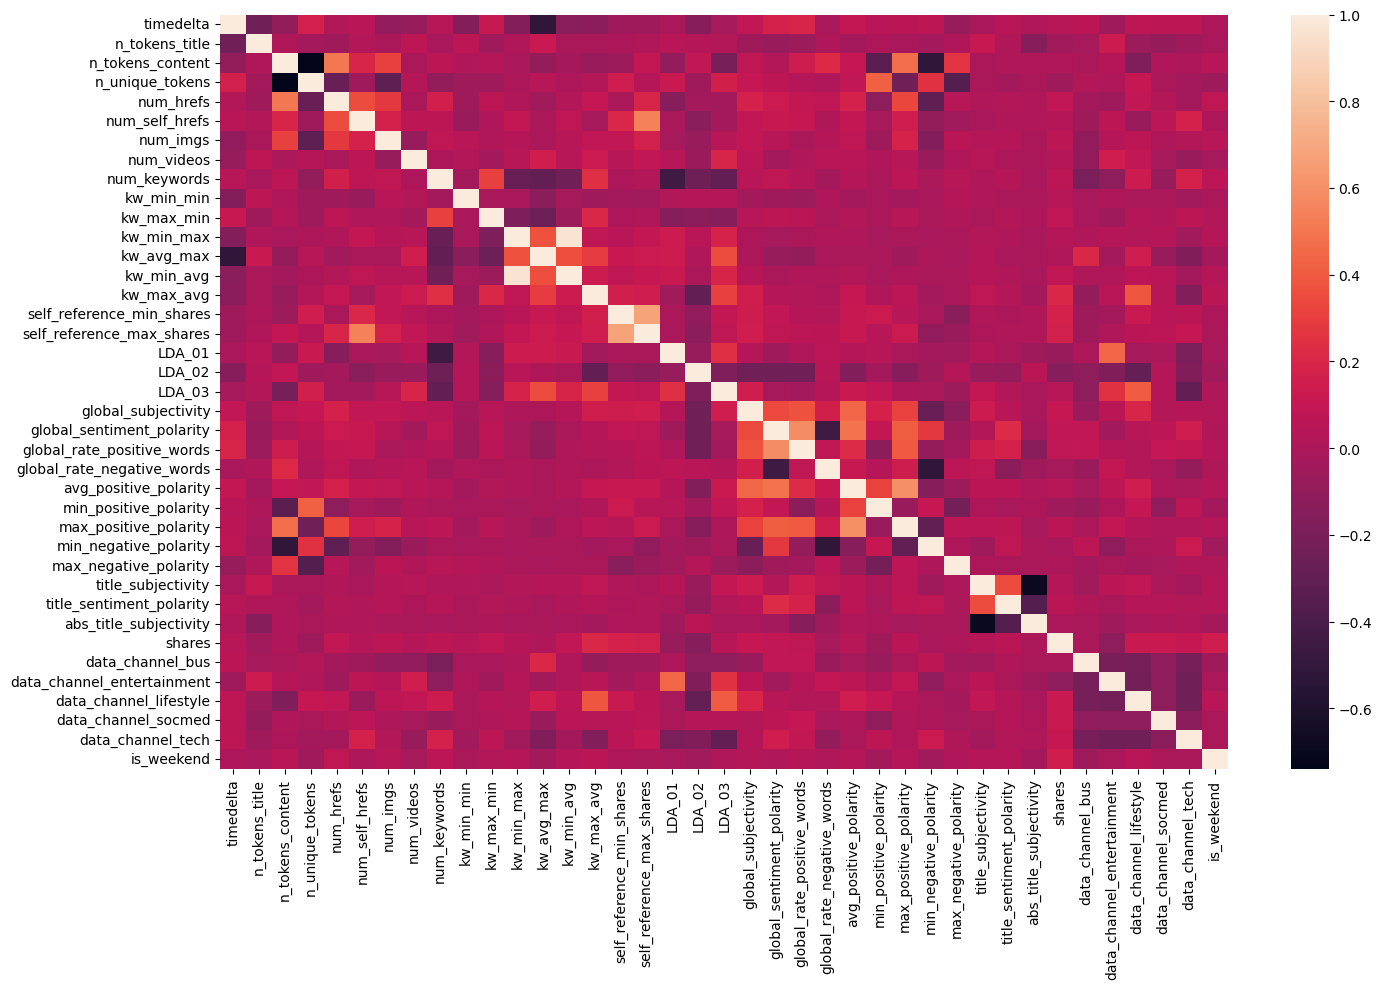

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

lda = ['LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'shares']

_, ax = plt.subplots(1,1, figsize=(15, 10))
sns.heatmap(working_df_dev.corr(method='spearman'), ax=ax)
plt.tight_layout()
plt.show()

In [29]:
formula = "shares ~ timedelta+n_tokens_title+n_tokens_content*n_unique_tokens+num_hrefs+num_self_hrefs+num_imgs+num_videos+num_keywords+kw_min_min+kw_max_min+kw_min_max+kw_avg_max+kw_min_avg+kw_max_avg+self_reference_min_shares*self_reference_max_shares+LDA_01+LDA_02+LDA_03+global_subjectivity+global_sentiment_polarity+global_rate_positive_words+global_rate_negative_words+avg_positive_polarity+min_positive_polarity+max_positive_polarity+min_negative_polarity+max_negative_polarity+title_subjectivity+shares+data_channel_bus+data_channel_entertainment+data_channel_lifestyle+data_channel_socmed+data_channel_tech+is_weekend"

model = sm.gls(formula, data = working_df_dev).fit()

print(model.summary())

                            GLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       1.000
Model:                            GLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.462e+29
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:44:01   Log-Likelihood:             8.8745e+05
No. Observations:               30410   AIC:                        -1.775e+06
Df Residuals:                   30370   BIC:                        -1.774e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------